# Exam - Sophia Wilson

In [52]:
# Standard libraires
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import scipy
from scipy import stats, interpolate
from scipy.optimize import minimize
import itertools
from iminuit import Minuit   
import copy
from tqdm.notebook import tqdm

# Nested fitting
import ultranest
from ultranest.plot import cornerplot
from ultranest.plot import PredictionBand


# External library
import sys  
from importlib import reload
sys.path.append('../') 
import AdvAppStatFunctions as aas

# setting for plotting
from matplotlib.patches import ConnectionPatch
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, precision_score
from sklearn.metrics import roc_curve, auc

In [3]:
import warnings
warnings.filterwarnings('ignore')

SaveFig = False
np.random.seed(18)

# Problem 4A

### Parsing data and setting label - change data and label

In [4]:
train = pd.read_csv('../Exam_other/Data/Exam_2022_Prob4_TrainData.csv', header=0, delimiter=',').iloc[:,1:-1]
train_class = pd.read_csv('../Exam_other/Data/Exam_2022_Prob4_TrainData.csv', header=0, delimiter=',').iloc[:,-1]

test = pd.read_csv('../Exam_other/Data/Exam_2022_Prob4_TestData.csv', header=0, delimiter=',').iloc[:,1:-1]
test_class = pd.read_csv('../Exam_other/Data/Exam_2022_Prob4_TestData.csv', header=0, delimiter=',').iloc[:,-1]

label = 'No show'
features = train.keys()

### Exploring training and testing data - change nrows, ncols

In [5]:
aas.explore_data(train, train_class, test, test_class, label)

Training data 
Total = 20000 
No show == 1: 4049 
No show == 0: 15951 
SN-ratio = 0.254

Testing data 
Total = 20000 
No show == 1: 4013 
No show == 0: 15987 
SN-ratio = 0.251


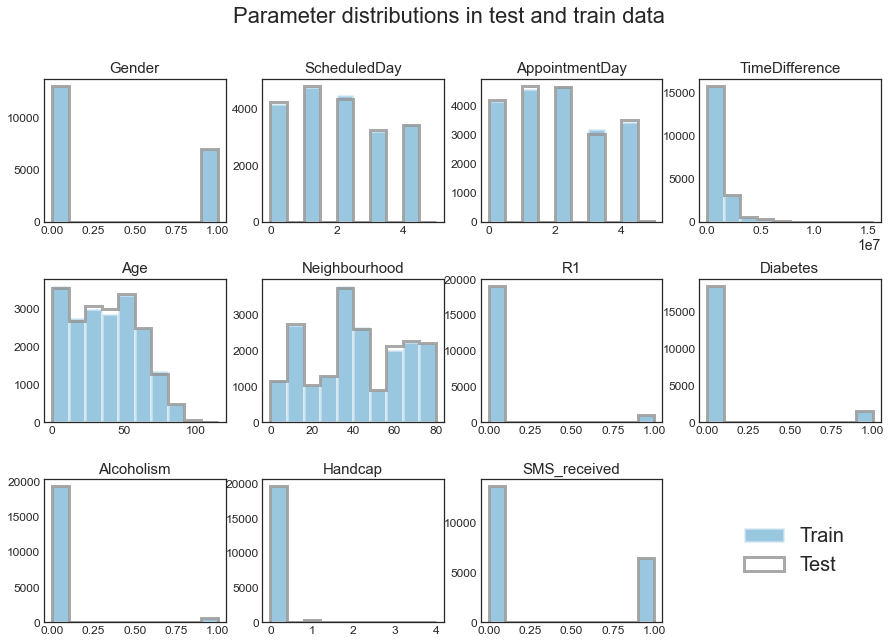

In [6]:
# Show 1D distributions
fig, ax = plt.subplots(nrows=3, ncols=4, gridspec_kw={'wspace':0.2, 'hspace':0.4}, figsize=(15,10))
fig.delaxes(ax[2,3])
ax = ax.flatten()

# Loop over features
for i in range(len(features)):
    ax[i].set_title(features[i], fontsize=15)
    ax[i].tick_params(axis="x", labelsize=12) 
    ax[i].tick_params(axis="y", labelsize=12) 
    
    _, bins_arr, _ = ax[i].hist(train[features[i]], bins=10, zorder=2,
                                linewidth=3, label='Train', color=color[0], alpha=0.4)
    ax[i].hist(test[features[i]], bins=bins_arr, zorder=2,
               histtype='step', linewidth=3, color=color[7], alpha=0.8, label='Test')
    
ax[10].legend(loc='center right', bbox_to_anchor=(2.1, 0.5), fancybox=True, shadow=True, fontsize=20)
fig.suptitle('Parameter distributions in test and train data', fontsize=22)
fig.tight_layout()
plt.show()

## Hyper parameter optimization

### Grid seach for max depth and n estimators

I use XGBClassifier as model for the gridsearch. The parameters found from this gridsearch will also work for other clf models.

In [19]:
%%time

# define model
model_temp = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=1,
                           learning_rate=0.1, use_label_encoder=False)

max_depth_range = [2,4,6,8,10]
n_estimators_range = [25,50,75,100,125,150]

# Specify parameters and distributions to sample from
parameters_GridSearch = {'max_depth': max_depth_range, 
                         'n_estimators': n_estimators_range}

# Chose number of iterations and number of folds
k = 5

GridSearch = GridSearchCV(model_temp, 
                          param_grid=parameters_GridSearch, 
                          cv=k, 
                          return_train_score=True,
                          scoring = 'accuracy')

# Fit the random search instance
GridSearch.fit(train, train_class);

# Get results
GridSearch_results = pd.DataFrame(GridSearch.cv_results_)                 
print("Grid Search: \tBest parameters: ", GridSearch.best_params_, f", Best scores: {GridSearch.best_score_:.3f}")

GridSearch_results.head(3)

Grid Search: 	Best parameters:  {'max_depth': 4, 'n_estimators': 75} , Best scores: 0.818
CPU times: user 11min 4s, sys: 1min 52s, total: 12min 57s
Wall time: 2min 23s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.099601,0.010605,0.003350,0.000633,2,25,"{'max_depth': 2, 'n_estimators': 25}",0.82275,0.81425,0.81900,...,0.81715,0.003430,9,0.815875,0.818000,0.816875,0.818250,0.817375,0.817275,0.000849
1,0.232655,0.062378,0.003303,0.000666,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.82300,0.81425,0.81925,...,0.81710,0.003717,10,0.815937,0.818063,0.816875,0.818688,0.817375,0.817388,0.000950
2,0.293942,0.042393,0.003278,0.000445,2,75,"{'max_depth': 2, 'n_estimators': 75}",0.82300,0.81450,0.81950,...,0.81720,0.003709,6,0.815875,0.818063,0.816875,0.818562,0.817500,0.817375,0.000938


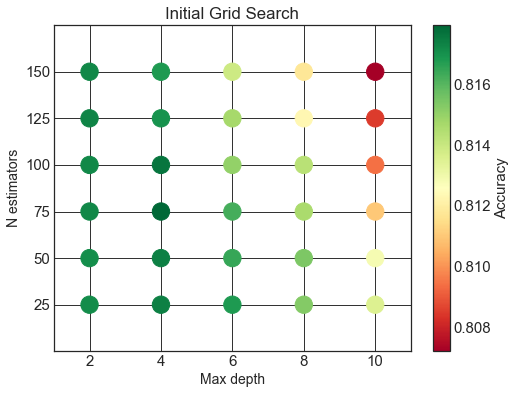

In [21]:
# parameters
x1 = GridSearch_results['param_max_depth']
x2 = GridSearch_results['param_n_estimators']

# color corresponding to test score
color = GridSearch_results['mean_test_score']
mini, maxi = np.min(color), np.max(color) 

# gridsearch
fig, ax = plt.subplots(figsize=(8,6))


im = ax.scatter(x1, x2, s=300, c = color, cmap='RdYlGn', zorder=2)

ax.set(xlabel='Max depth', ylabel='N estimators', title='Initial Grid Search', 
       xlim=(max_depth_range[0]-1,max_depth_range[-1]+1), ylim=(n_estimators_range[0]-25,n_estimators_range[-1]+25),
       xticks = max_depth_range, yticks=n_estimators_range)

ax.tick_params(axis="x", labelsize=15) 
ax.tick_params(axis="y", labelsize=15)
ax.grid(color='k')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Accuracy', fontsize=15, x=1.7)
cbar.ax.tick_params(labelsize=15);

### redo gridsearch in area with highest accuracy

In [22]:
%%time

max_depth_range_2 = [2,3,4,5,6]
n_estimators_range_2 = [50,60,70,80,90,100]


parameters_GridSearch2 = {'max_depth': max_depth_range_2, 
                         'n_estimators': n_estimators_range_2}

# number of iterations and number of folds
k = 5

GridSearch2 = GridSearchCV(model_temp, 
                           param_grid=parameters_GridSearch2, 
                           cv=k, 
                           return_train_score=True,
                           scoring = 'accuracy')

# Fit the random search instance
GridSearch2.fit(train, train_class);

# Get results
GridSearch2_results = pd.DataFrame(GridSearch2.cv_results_)                 
print("Grid Search: \tBest parameters: ", GridSearch2.best_params_, f", Best scores: {GridSearch2.best_score_:.3f}")

GridSearch2_results.head(3)

Grid Search: 	Best parameters:  {'max_depth': 4, 'n_estimators': 80} , Best scores: 0.818
CPU times: user 6min 23s, sys: 1min 5s, total: 7min 29s
Wall time: 1min 24s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.226591,0.046839,0.003267,0.000647,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.823,0.81425,0.81925,...,0.81710,0.003717,17,0.815937,0.818063,0.816875,0.818688,0.817375,0.817388,0.000950
1,0.247926,0.029007,0.003246,0.000807,2,60,"{'max_depth': 2, 'n_estimators': 60}",0.823,0.81425,0.81925,...,0.81710,0.003717,17,0.815875,0.818125,0.816875,0.818562,0.817375,0.817362,0.000946
2,0.275646,0.020012,0.013784,0.019653,2,70,"{'max_depth': 2, 'n_estimators': 70}",0.823,0.81450,0.81925,...,0.81715,0.003680,15,0.815875,0.818063,0.817000,0.818562,0.817438,0.817388,0.000925


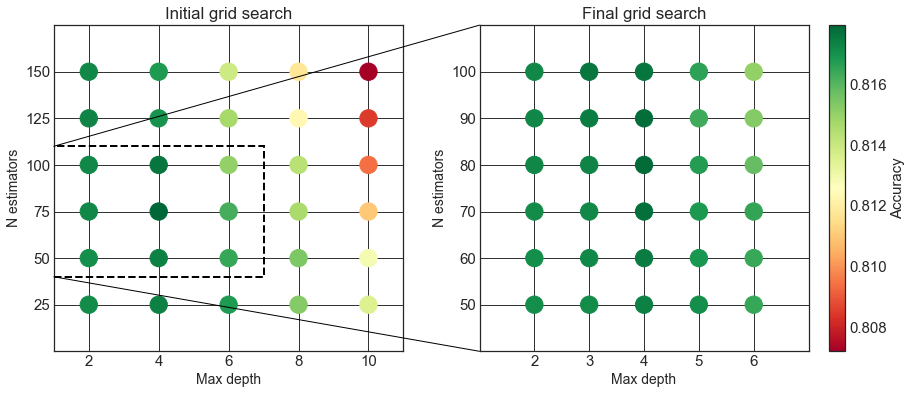

In [25]:
# parameters from second gridsearch
x1_2 = GridSearch2_results['param_max_depth']
x2_2 = GridSearch2_results['param_n_estimators']

# color 
color2 = GridSearch2_results['mean_test_score']
mini, maxi = np.min(np.concatenate((color,color2))), np.max(np.concatenate((color,color2))) #color ranges

# figure
fig, ax = plt.subplots(ncols=2, figsize=(15,6), gridspec_kw={'wspace':0.2, 'width_ratios':(1.7,2)})

# initial random search
ax[0].scatter(x1, x2, s=300, c = color, cmap='RdYlGn', zorder=2)
ax[0].grid(color='k')

ax[0].set(xlabel='Max depth', ylabel='N estimators', title='Initial grid search', 
       xlim=(max_depth_range[0]-1,max_depth_range[-1]+1), ylim=(n_estimators_range[0]-25,n_estimators_range[-1]+25),
       xticks = max_depth_range, yticks=n_estimators_range)

ax[0].tick_params(axis="x", labelsize=15) 
ax[0].tick_params(axis="y", labelsize=15)


# final search
im2 = ax[1].scatter(x1_2, x2_2, s=300, c = color2, cmap='RdYlGn', zorder=2, vmin=mini, vmax=maxi)
ax[1].grid(color='k')

ax[1].set(xlabel='Max depth', ylabel='N estimators', title='Final grid search', 
       xlim=(max_depth_range_2[0]-1,max_depth_range_2[-1]+1), ylim=(n_estimators_range_2[0]-10,n_estimators_range_2[-1]+10),
       xticks = max_depth_range_2, yticks=n_estimators_range_2)

ax[1].tick_params(axis="x", labelsize=15) 
ax[1].tick_params(axis="y", labelsize=15)


# Shared colorbar
cbar = fig.colorbar(im2, ax=ax[1])
cbar.set_label('Accuracy', fontsize=15, x=1.7)
cbar.ax.tick_params(labelsize=15)


# Mark the zoom in plot ------------------------
xlim2 = (1,7)
ylim2 = (40,110)

# Square (x,y,width,height)
rect = patches.Rectangle((xlim2[0],ylim2[0]), xlim2[1]-xlim2[0], ylim2[1]-ylim2[0], linewidth=2, edgecolor='k', facecolor='none', linestyle='dashed')
ax[0].add_patch(rect)
# Lines
line1 = patches.ConnectionPatch(xyA=(xlim2[0],ylim2[1]), xyB=(xlim2[0],ylim2[1]), coordsA=ax[0].transData, coordsB=ax[1].transData)
line1.set_color([0, 0, 0])
fig.add_artist(line1)
line2 = patches.ConnectionPatch(xyA=(xlim2[0],ylim2[0]), xyB=(xlim2[0],ylim2[0]), coordsA=ax[0].transData, coordsB=ax[1].transData)
line2.set_color([0, 0, 0])
fig.add_artist(line2)

    
plt.show()

### Use the best hyper parameters for classifier

In [26]:
max_depth_GS = GridSearch2.best_params_['max_depth']
n_estimators_GS = GridSearch2.best_params_['n_estimators']
print('We use max depth:', max_depth_GS, 'and n_estimators:', n_estimators_GS)

We use max depth: 4 and n_estimators: 80


## Train algorithm

In [27]:
# Training data
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth_GS, splitter='best'), algorithm="SAMME", n_estimators=n_estimators_GS)
clf = clf.fit(train, train_class)

# Testing our algorithm on the training and testing data
twoclass_output_train = clf.decision_function(train)
twoclass_output_test = clf.decision_function(test)

### Evaluate output for confusion matrix - assumes cut at 0 !

In [28]:
twoclass_output_train_cm = aas.twoclass_output_for_cm(twoclass_output_train)
twoclass_output_test_cm = aas.twoclass_output_for_cm(twoclass_output_test)

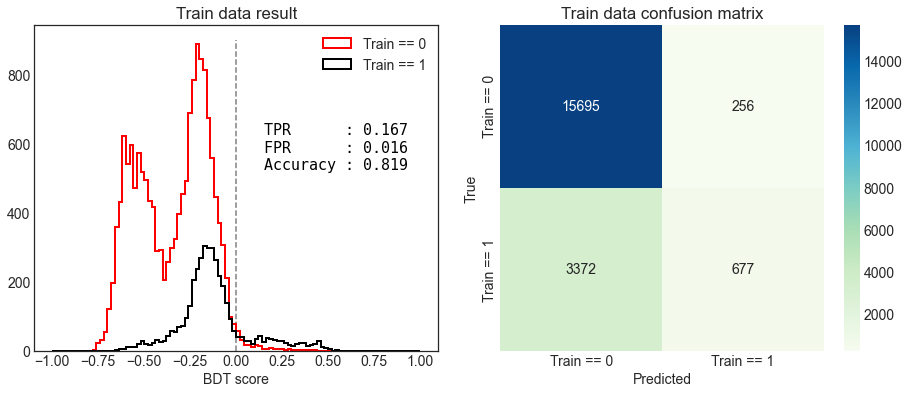

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(13,5.7))
hist0_train, hist1_train, vals_train = aas.clf_result(twoclass_output_train, twoclass_output_train_cm, train_class, 'Train', axes)

# true positive rate, false positive rate and accuracy
tpr_train = aas.TPR(vals_train[3], vals_train[2])
fpr_train = aas.FPR(vals_train[1], vals_train[0])
accuracy_train = accuracy_score(y_true=train_class, y_pred=twoclass_output_train_cm)


d = {r'TPR      :': tpr_train,
     r'FPR      :': fpr_train,
     r'Accuracy :': accuracy_train
         }
    
text = aas.nice_string_output(d, extra_spacing=1, decimals=3)
aas.add_text_to_ax(0.57, 0.7, text, axes[0], fontsize=15, color='k')

fig.tight_layout()

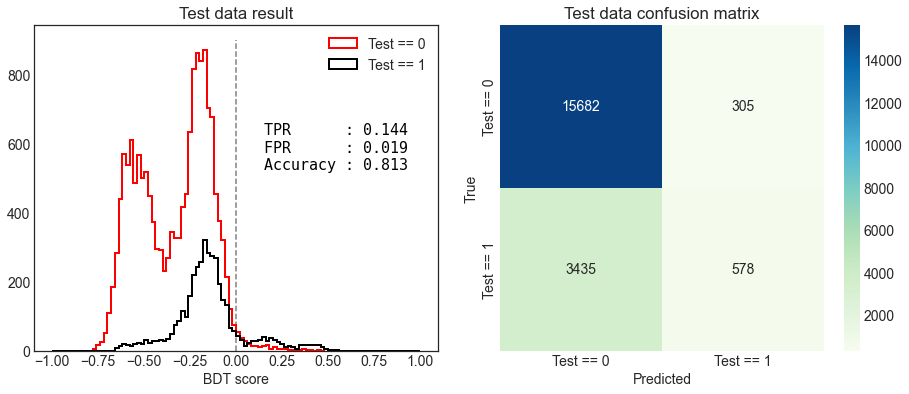

In [68]:
fig, axes = plt.subplots(1, 2,figsize=(13,5.7))
hist0_test, hist1_test, vals_test = aas.clf_result(twoclass_output_test, twoclass_output_test_cm, test_class, 'Test', axes)

tpr_test = aas.TPR(vals_test[3], vals_test[2])
fpr_test = aas.FPR(vals_test[1], vals_test[0])
accuracy_test = accuracy_score(y_true=test_class, y_pred=twoclass_output_test_cm)

d = {r'TPR      :': tpr_test,
     r'FPR      :': fpr_test,
     r'Accuracy :': accuracy_test
         }
    
text = aas.nice_string_output(d, extra_spacing=1, decimals=3)
aas.add_text_to_ax(0.57, 0.7, text, axes[0], fontsize=15, color='k')

fig.tight_layout()

### ROC curve 

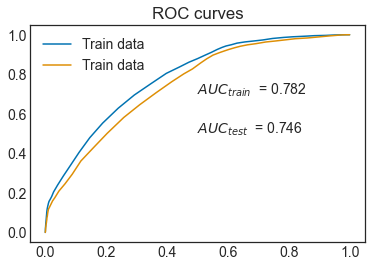

In [65]:
fig, ax = plt.subplots()
aas.clf_roc(hist0_train, hist1_train, hist0_test, hist1_test, ax)

In [69]:
print('Train:')
print('Accuracy:',  accuracy_train)
print('True positive rate =', tpr_train)
print('False positive rate =', fpr_train)

print('\nTest:')
print('Accuracy:',  accuracy_test)
print('True positive rate =', tpr_test)
print('False positive rate =', fpr_test)

Train:
Accuracy: 0.8186
True positive rate = 0.16720177821684368
False positive rate = 0.01604915052347815

Test:
Accuracy: 0.813
True positive rate = 0.14403189633690505
False positive rate = 0.019078000875711515


### Feature importance based on mean decrease in impurity

Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

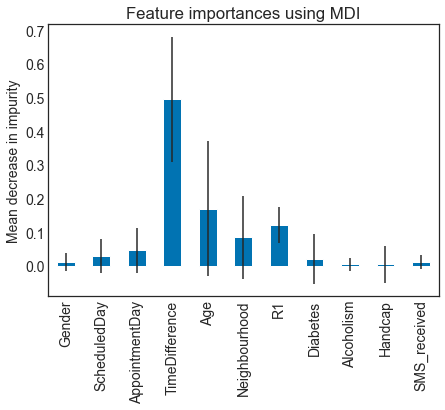

In [70]:
fig, ax = plt.subplots(figsize=(7,5))
aas.feature_importance_mdi(clf, features, ax, print_table=False)

### Feature importance based on MDI and on feature permutation

Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

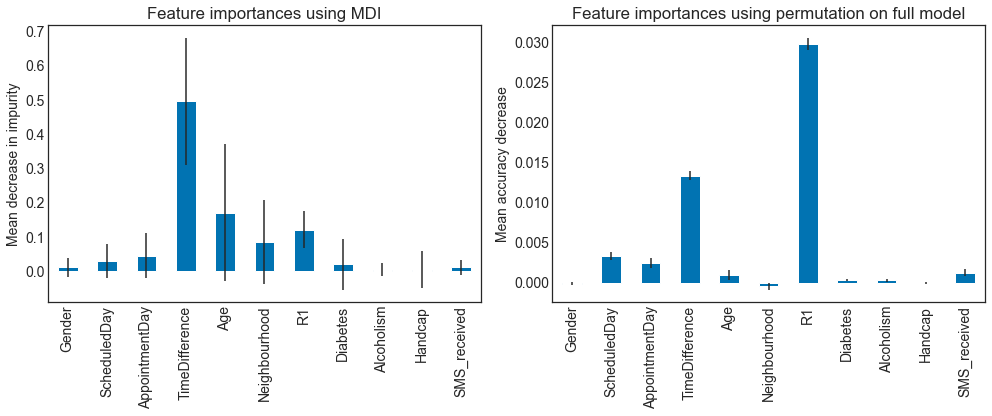

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
aas.feature_importance(clf, features, test, test_class, axes, print_table=False)
fig.tight_layout()

## Blind data

In [ ]:
# Blind data
blinddata = np.genfromtxt('Data/Exam_2022_Prob4_BlindData.csv', delimiter=',', skip_header=1)[:,1:] 
twoclass_output_blind = clf.decision_function(blinddata)
twoclass_output_blind[twoclass_output_blind>0]=1
twoclass_output_blind[twoclass_output_blind<0]=0

IDs = np.genfromtxt('Data/Exam_2022_Prob4_BlindData.csv', delimiter=',', skip_header=1)[:,0] 
IDs_true = IDs[twoclass_output_blind == 1]
IDs_false = IDs[twoclass_output_blind == 0]

print(f'Blind data \nTotal = %s \n%s == 1: %s \n%s == 0: %s \nSN-ratio = %s' \
          %(len(blinddata), label, len(IDs_true), label, len(IDs_false), round(len(IDs_true)/len(IDs_false), 3)))

In [ ]:
#np.savetxt('Wilson.Problem4.RevenueTrue.txt', IDs_true)
#np.savetxt('Wilson.Problem4.RevenueFalse.txt', IDs_false)